<a href="https://colab.research.google.com/github/shsieh005/ProjectAI/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
num_epochs = 2
batch_size = 64
learning_rate = 1e-4 #0.0001

In [5]:
transform = transforms.Compose(
    [ transforms.Resize([224, 224]),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
iterator = iter(train_loader)
images,labels = next(iterator)
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [7]:
def show(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

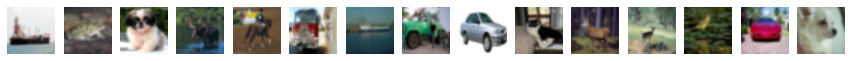

In [8]:
fig, axes = plt.subplots(1,15, figsize=(15, 15))
for i in range(15):
  axes[i].imshow(show(images[i]))
  axes[i].set_axis_off()
fig.show()

# VGG from Scratch

In [9]:
VGG_types = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [13]:
class VGG_net(nn.Module):
    def __init__(self, mode, in_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types[mode])
        
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10),
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture: 
            if type(x) == int:
                out_channels = x
                
                layers += [nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
                
        return nn.Sequential(*layers)

In [14]:
vgg16 = VGG_net(mode='VGG16').to(device)

In [15]:
print(vgg16)


VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)

In [17]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
count_parameters(vgg16)

27573834

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 3, 224, 224]
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = vgg16(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 30 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [30/782], Loss: 2.1538
Epoch [1/2], Step [60/782], Loss: 1.8950
Epoch [1/2], Step [90/782], Loss: 1.7979
Epoch [1/2], Step [120/782], Loss: 1.6136
Epoch [1/2], Step [150/782], Loss: 1.6162
Epoch [1/2], Step [180/782], Loss: 1.8970
Epoch [1/2], Step [210/782], Loss: 1.7218
Epoch [1/2], Step [240/782], Loss: 1.5064
Epoch [1/2], Step [270/782], Loss: 1.8141
Epoch [1/2], Step [300/782], Loss: 1.5264
Epoch [1/2], Step [330/782], Loss: 1.5452
Epoch [1/2], Step [360/782], Loss: 1.3728
Epoch [1/2], Step [390/782], Loss: 1.2051
Epoch [1/2], Step [420/782], Loss: 1.4674
Epoch [1/2], Step [450/782], Loss: 1.4661
Epoch [1/2], Step [480/782], Loss: 1.5039
Epoch [1/2], Step [510/782], Loss: 1.0379
Epoch [1/2], Step [540/782], Loss: 1.1878
Epoch [1/2], Step [570/782], Loss: 1.2572
Epoch [1/2], Step [600/782], Loss: 1.1326
